In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OrdinalEncoder, MinMaxScaler
import matplotlib.pyplot as plt

# Preproccesing

In [2]:
def power(x):
    return x ** 0.6

In [3]:
def sum_family(X):
   return (X[:, 0] + X[:, 1]).reshape(-1, 1)

In [4]:
def family_feature_names_out(input_features):
    return ["FamilySize"]

In [5]:
attributes_to_drop = ['Name', 'Ticket', 'Cabin', 'Embarked']
attributes_to_sum = ['SibSp', 'Parch']

In [6]:
age_pipeline = make_pipeline(
    IterativeImputer(),
    FunctionTransformer(power),
    MinMaxScaler(feature_range=(0, 1))
)

In [7]:
preprocessing = ColumnTransformer([
    ("drop1", "drop", ["Name", "Ticket", "Cabin", "Embarked"]),
    ("fare", MinMaxScaler(feature_range=(0, 1)), ["Fare"]),
    ("1hotencoder", OrdinalEncoder(), ["Sex"]),
    ("family", FunctionTransformer(sum_family, validate=True, feature_names_out=family_feature_names_out), ["SibSp", "Parch"]),
    ("drop2", "drop", ["SibSp", "Parch"]),
    ("age", age_pipeline, ["Age"])
],
remainder='passthrough',
force_int_remainder_cols = False)

# Models

## SGD (Stochastic Gradient Descent)

In [8]:
from sklearn.linear_model import SGDClassifier

In [9]:
data_sdg = pd.read_csv('../titanic/train.csv')

In [10]:
passenger_id = data_sdg['PassengerId'].copy()
labels_sdg = data_sdg['Survived'].copy()
data_sdg.drop('PassengerId', axis=1, inplace=True)
data_sdg.drop('Survived', axis=1, inplace=True)

In [11]:
sdg_class = make_pipeline(
    preprocessing,
    SGDClassifier(random_state=42)
)

sdg_class.fit(data_sdg, labels_sdg)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop1', 'drop',
                                                  ['Name', 'Ticket', 'Cabin',
                                                   'Embarked']),
                                                 ('fare', MinMaxScaler(),
                                                  ['Fare']),
                                                 ('1hotencoder',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('family',
                                                  FunctionTransformer(feature_names_out=<function family_feature_names_out at 0x1270f4d60>,
                                                                      func=<function sum_family at 0x1270f4cc0>,
                                                                      validate=True),
                                                  ['SibSp', 'Parch']),
                                                 ('drop2', 'drop',
                                                  ['SibSp', 'Parch']),
                                                 ('age',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function power at 0x1270f4b80>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age'])])),
                ('sgdclassifier', SGDClassifier(random_state=42))])

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sdg_class, data_sdg, labels_sdg, cv=3, scoring='accuracy')

array([0.62962963, 0.79124579, 0.7979798 ])

In [13]:
from sklearn.dummy import DummyClassifier

dummy_class = DummyClassifier()
dummy_class.fit(data_sdg, labels_sdg)
cross_val_score(dummy_class, data_sdg, labels_sdg, cv=3, scoring='accuracy')

array([0.61616162, 0.61616162, 0.61616162])

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [15]:
labels_sdg_pred = cross_val_predict(sdg_class, data_sdg, labels_sdg, cv=3)

In [16]:
confusion_matrix(labels_sdg, labels_sdg_pred)

array([[421, 128],
       [104, 238]])

* 421 were correctly classified as no survival while being no survival (TRUE NEGATIVE)
* 128 were wrongly classified as survival while being no survival (FALSE POSITIVE)
* 104 were wrongly classified as no survival while being surival (FALSE NEGATIVE)
* 238 were correctly classified as survival while being survival (TRUE POSITIVE)

In [17]:
precision_score_sdg = precision_score(labels_sdg, labels_sdg_pred)
precision_score_sdg

0.6502732240437158

In [18]:
recall_score_sdg = recall_score(labels_sdg, labels_sdg_pred)
recall_score_sdg

0.695906432748538

In [19]:
f1_score_sdg = f1_score(labels_sdg, labels_sdg_pred)
f1_score_sdg

0.672316384180791

In [20]:
scores_sdg = cross_val_predict(sdg_class, data_sdg, labels_sdg, cv=3,
                               method='decision_function')

In [21]:
from sklearn.metrics import precision_recall_curve

precisions_sdg, recalls_sdg, tresholds_sdg = precision_recall_curve(labels_sdg, scores_sdg)

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels_sdg, scores_sdg)

np.float64(0.7927172211037612)

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
data_forest = pd.read_csv('../titanic/train.csv')

In [25]:
passenger_id = data_forest['PassengerId'].copy()
labels_forest = data_forest['Survived'].copy()
data_forest.drop('PassengerId', axis=1, inplace=True)
data_forest.drop('Survived', axis=1, inplace=True)

In [26]:
forest_class = make_pipeline(
    preprocessing,
    RandomForestClassifier(random_state=42)
)

In [27]:
forest_class.fit(data_forest, labels_forest)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop1', 'drop',
                                                  ['Name', 'Ticket', 'Cabin',
                                                   'Embarked']),
                                                 ('fare', MinMaxScaler(),
                                                  ['Fare']),
                                                 ('1hotencoder',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('family',
                                                  FunctionTransformer(feature_names_out=<function family_feature_names_out at 0x1270f4d60>,
                                                                      fu...sum_family at 0x1270f4cc0>,
                                                                      validate=True),
                                                  ['SibSp', 'Parch']),
                                                 ('drop2', 'drop',
                                                  ['SibSp', 'Parch']),
                                                 ('age',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function power at 0x1270f4b80>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

cross-validation

In [28]:
from sklearn.model_selection import cross_val_score

cross_val_score(forest_class, data_forest, labels_forest, cv=3, scoring="accuracy")

array([0.78451178, 0.83501684, 0.81481481])

In [29]:
from sklearn.dummy import DummyClassifier

dummy_class = DummyClassifier()
dummy_class.fit(data_forest, labels_forest)
cross_val_score(dummy_class, data_forest, labels_forest, cv=3, scoring='accuracy')

array([0.61616162, 0.61616162, 0.61616162])

confusion matrix

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [31]:
labels_forest_pred = cross_val_predict(forest_class, data_forest, labels_forest)

In [32]:
confusion_matrix(labels_forest, labels_forest_pred)

array([[478,  71],
       [ 85, 257]])

* 478 were correctly classified as no survival while being no survival (TRUE NEGATIVE)
* 71 were wrongly classified as survival while being no survival (FALSE POSITIVE)
* 85 were wrongly classified as no survival while being surival (FALSE NEGATIVE)
* 257 were correctly classified as survival while being survival (TRUE POSITIVE)

In [33]:
precision_score(labels_forest, labels_forest_pred)

0.7835365853658537

In [34]:
recall_score(labels_forest, labels_forest_pred)

0.7514619883040936

* The model is only correct 78.3% when it claims that a person survived
* The model only detects 75.1% of the people that survived

In [35]:
f1_score(labels_forest, labels_forest_pred)

0.7671641791044777

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

In [37]:
y_probas_forest = cross_val_predict(forest_class, data_forest, labels_forest,
                                    cv=3, method='predict_proba')
scores_forest = y_probas_forest[:, 1]

In [38]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(labels_forest, scores_forest)

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels_forest, scores_forest)

np.float64(0.8541127408685648)

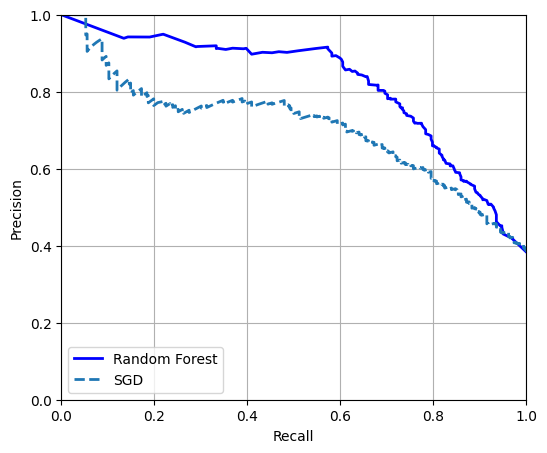

In [40]:
plt.figure(figsize=(6, 5)) 

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls_sdg, precisions_sdg, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

## Final

In [41]:
import joblib

In [42]:
model = forest_class = make_pipeline(
    preprocessing,
    RandomForestClassifier(random_state=42)
)

model.fit(data_forest, labels_forest)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop1', 'drop',
                                                  ['Name', 'Ticket', 'Cabin',
                                                   'Embarked']),
                                                 ('fare', MinMaxScaler(),
                                                  ['Fare']),
                                                 ('1hotencoder',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('family',
                                                  FunctionTransformer(feature_names_out=<function family_feature_names_out at 0x1270f4d60>,
                                                                      fu...sum_family at 0x1270f4cc0>,
                                                                      validate=True),
                                                  ['SibSp', 'Parch']),
                                                 ('drop2', 'drop',
                                                  ['SibSp', 'Parch']),
                                                 ('age',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function power at 0x1270f4b80>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [43]:
joblib.dump(model, 'random_forest.pkl')

['random_forest.pkl']